## Preprocessing single cell/nucleus data from R (in .csv format)

In [1]:
#!source activate vizi && pip install ...
#!source activate vizi && conda install -n vizi -c conda-forge ... -y

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# external dependencies
import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)
# import custom modules
import utils
import models
import dataloaders

# basic imports
import json
import pprint
import pickle
import logging
from tqdm.auto import tqdm, trange

# scientific python
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

# Scanpy modules
import scanpy as sc
import anndata

logger = logging.getLogger()
utils.matplotlib_settings()
utils.print_module_versions([sc, anndata])

scanpy    : 1.6.0
anndata   : 0.7.4


## Load the data

In [3]:
# enble if data is already loaded from CSV and saved to NumPy
load_from_npy = False

# plot useful diagnostic plots
plot_diagnostics = True

# if set to False, then `interesting_gene_names` must be set
perform_hvg = True

In [4]:
# puck data prefix
PREFIX = 'citeseq_rna'#'sn'

# for cerebellum
interesting_gene_names = [
    'Nphs2', 'Wt1', 'Synpo', 'Kdr', 'Pecam1', 
    'Plvap', 'Ehd3', 'Itga8', 'Ptn', 'Ctgf',
    'Col4a3', 'Lrp2', 'Muc1', 'Atp11a', 
    'Slc5a1', 'Napsa', 'Pck1', 'Umod', 
    'Emx1', 'Enpp2', 'Slc12a1', 'Aqp2',
    'Aqp6', 'Slc12a1', 'Nos1', 'Ren1','Gapdh', 'Umod',
    'CAR8', 'Gabra6', 'Slc17a6', 'Ttr', 'Apoe', 'C1qb',
    'Slc1a3', 'pcp4', 'aldoc', 'mybpc1', 'plcb4']

### GCP load data

In [101]:
PUCK_SUBNUMBER = 'naiveB_1900'#'mli2_30'
PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_1404' #f'{PUCK_SUBNUMBER}genes_0.05_perturbed'
#gene_expression_csv_path = f'../data/{PUCK_NUMBER}/{PUCK_NUMBER}_counts.csv'
output_path = f'../data/{PUCK_NUMBER}/'

if not os.path.exists(output_path):
    os.mkdir(output_path)

In [102]:
if load_from_npy:

    logging.warning(f'Loading data for {PREFIX} from NumPy files...')
    expression_gn = np.load(os.path.join(output_path, f'{PREFIX}_expression.npy'))
    gene_names = np.load(os.path.join(output_path, f'{PREFIX}_gene_names.npy'))
    barcodes = np.load(os.path.join(output_path, f'{PREFIX}_barcodes.npy'))

else:
    
    logging.warning(f'Loading data for {PREFIX} from CSV files...')
       
    #counts = pd.read_csv(f"latent_space_structure/data/mli2/{PUCK_NUMBER}_genes_counts.csv")
    #counts = pd.read_csv(f"latent_space_structure/data/mli2/{PUCK_SUBNUMBER}genes_counts.csv")
    counts = pd.read_csv(f"latent_space_structure/data/{PUCK_NUMBER}/counts_allgenes.csv")
    barcodes = counts.index.values
    counts.reset_index(inplace=True, drop=True)
    counts['barcode'] = barcodes
    barcodes = [str(item) for item in counts.barcode.values]
    counts = counts.set_index("barcode")

    gene_names = np.asarray(counts.columns.values)
    expression_gn = counts.values.T

    logging.warning(f'Saving data for {PREFIX} from to NumPy...')    
    np.save(os.path.join(output_path, f'{PREFIX}_expression.npy'), expression_gn)
    np.save(os.path.join(output_path, f'{PREFIX}_gene_names.npy'), gene_names)
    np.save(os.path.join(output_path, f'{PREFIX}_barcodes.npy'), barcodes)    

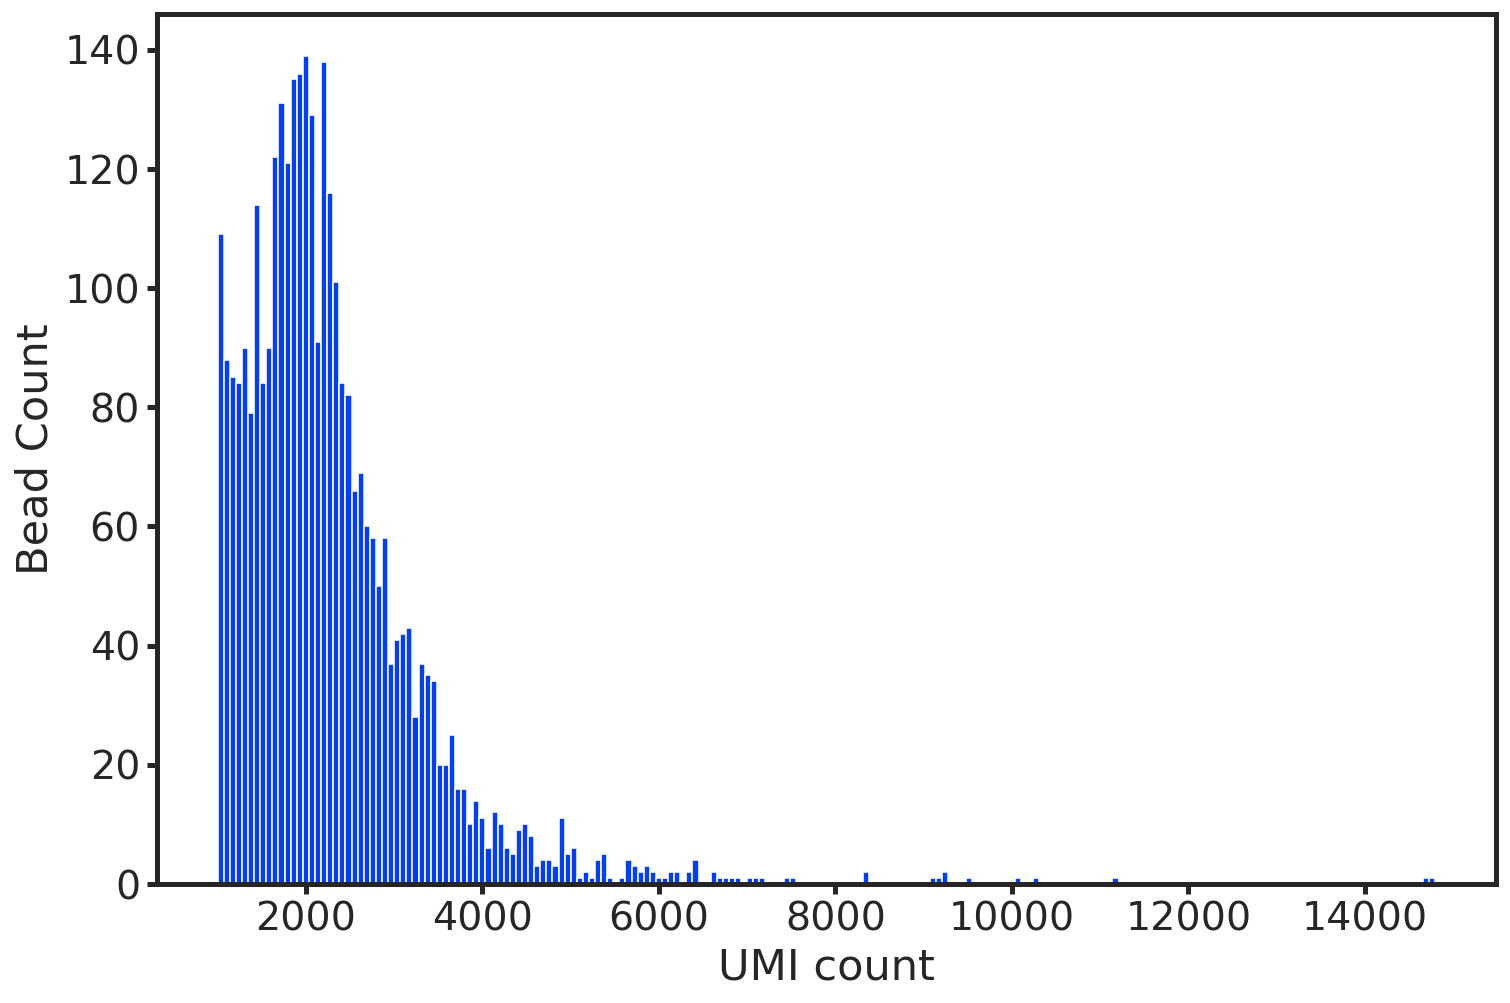

In [103]:
# estimate bead efficiency (i.e. normalized UMI count before subsetting genes)
raw_umi_n = np.sum(expression_gn, axis=0).astype(np.float)
mean_umi = np.mean(raw_umi_n)
bead_efficiency_n = raw_umi_n / mean_umi

if plot_diagnostics:
    fig = plt.figure()
    ax = plt.gca()
    ax.hist(raw_umi_n, bins=200);
    ax.set_xlabel('UMI count')
    ax.set_ylabel('Bead Count')

/opt/conda/envs/vizi/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


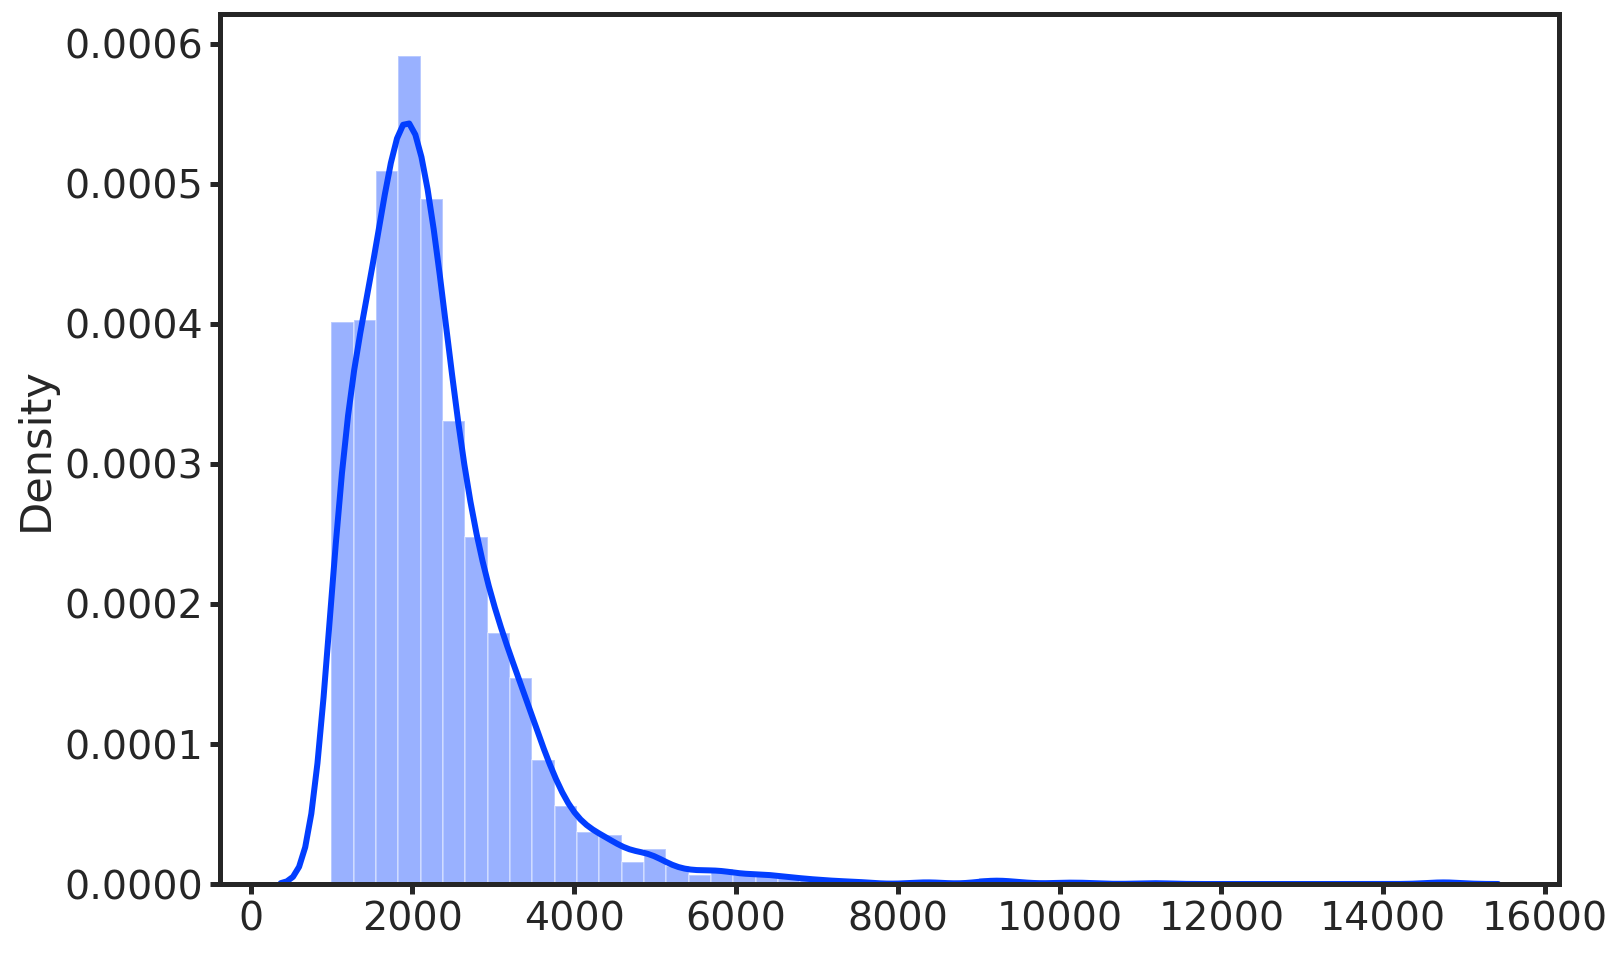

In [104]:
sns.distplot(bead_efficiency_n * mean_umi); plt.show()

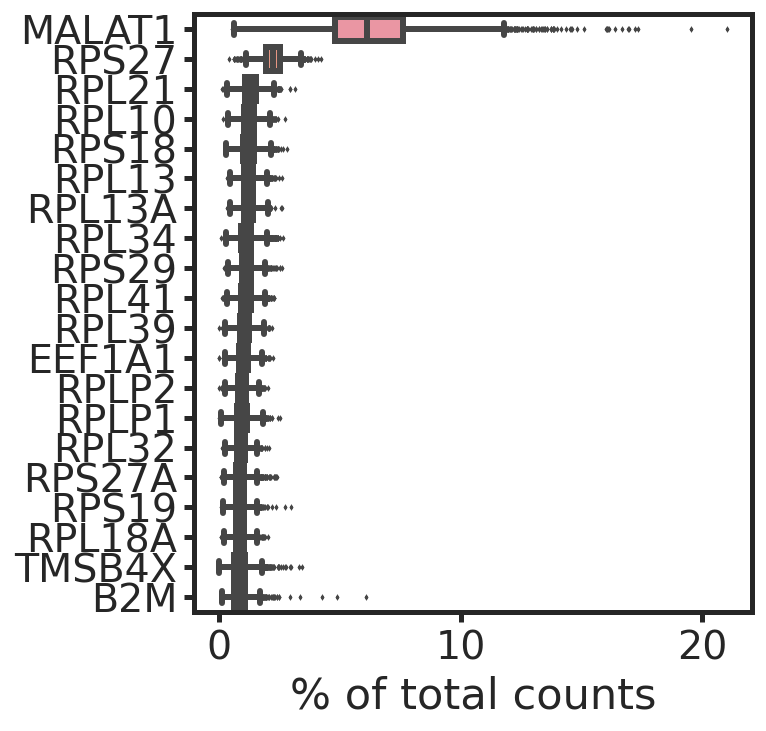

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/opt/conda/envs/vizi/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/envs/vizi/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/conda/envs/vizi/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation

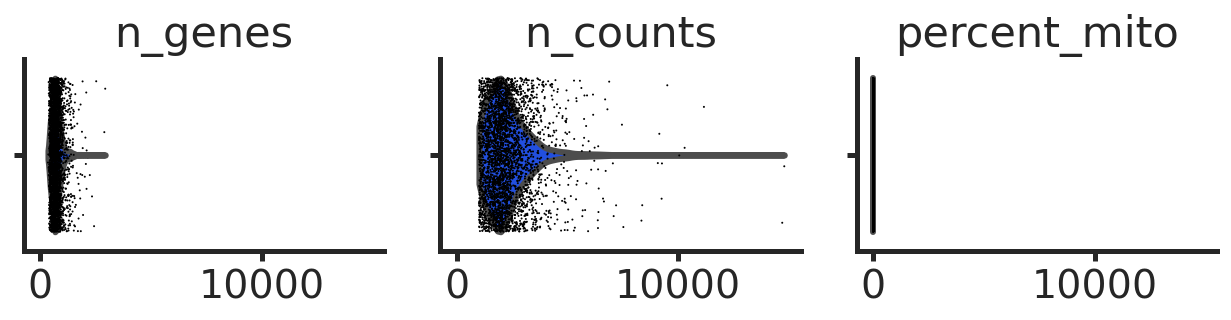

Number of HVGs: 17009


In [105]:
if perform_hvg:

    logging.warning('Actually not selecting highly variable genes...')
    
    adata = sc.AnnData(expression_gn.T)
    adata.var_names = anndata.utils.make_index_unique(pd.Index(gene_names))
    adata.var['gene_ids'] = gene_names
    adata.obs['barcodes'] = pd.Index(barcodes, name=0)
    adata.raw = adata

    if plot_diagnostics:
        sc.pl.highest_expr_genes(adata, n_top=20)

    # filter beads    
    sc.pp.filter_cells(adata, min_genes=20)
    mito_genes = adata.var_names.str.startswith('mt-')
    adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
    adata.obs['n_counts'] = adata.X.sum(axis=1)

    #adata = adata[adata.obs['n_genes'] > 10, :]
    #adata = adata[adata.obs['percent_mito'] < 0.3, :]

    if plot_diagnostics:
        sc.pl.violin(
            adata, ['n_genes', 'n_counts', 'percent_mito'],
            jitter=0.4, multi_panel=True)

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    #sc.pp.highly_variable_genes(adata, min_mean=0.03, max_mean=5, min_disp=0.9) #min_mean=0.01, max_mean=4, min_disp=0.2

    #if plot_diagnostics:
    #    sc.pl.highly_variable_genes(adata)

    #adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=1.2)

    #df_meta = pd.read_csv(bead_location_csv_path)
    #barcodes_df = pd.DataFrame(barcodes)
    #barcodes_df.columns = ['barcode']
    #df_meta_clean = barcodes_df.merge(df_meta, left_on='barcode', right_on='barcode')

    #filtered_gene_indices_bool = [ x in adata.var['highly_variable'] for x in gene_names ]
    filtered_expression_gn = expression_gn#[filtered_gene_indices_bool, :]
    #nonzero_bead_indecies_bool = filtered_expression_gn.sum(axis=0)!=0
    #nonzero_barcodes = df_meta_clean[nonzero_bead_indecies_bool]['barcode'].values
    #adata_barcodes = adata.obs['barcodes'].values
    #barcodes_intersection = list(set(adata_barcodes) & set(nonzero_barcodes))
    #bead_barcodes = df_meta_clean['barcode'].values
    #bead_intersection_bool = [ x in barcodes_intersection for x in bead_barcodes ] 
    #adata_intersection_bool = [ x in nonzero_barcodes for x in adata_barcodes ] 

    leiden_n = adata.obs['leiden']#[adata_intersection_bool].values
    #bead_x_positions_n = df_meta_clean.iloc[bead_intersection_bool]['x'].values
    #bead_y_positions_n = df_meta_clean.iloc[bead_intersection_bool]['y'].values
    bead_barcodes_n = adata.obs['barcodes'].values#df_meta_clean.iloc[bead_intersection_bool]['barcode'].values
    bead_efficiency_n = bead_efficiency_n#[bead_intersection_bool]
    #filtered_expression_gn = filtered_expression_gn.T[bead_intersection_bool].T
    total_umi_hvgs_n = np.sum(expression_gn, axis=0).astype(np.float)
    mean_umi_hvgs = np.mean(total_umi_hvgs_n)
    bead_efficiency_hvgs_n = total_umi_hvgs_n / mean_umi_hvgs
    filtered_gene_names = gene_names#adata.var['highly_variable'].index #gene_names[filtered_gene_indices]
    print(f"Number of HVGs: {filtered_gene_names.shape[0]}")
    
else:

    print("Implement selection based on a list of genes of interest.")
    
n_filtered_genes = filtered_expression_gn.shape[0]

# Save preprocessed data in custom folder

In [106]:
adata

AnnData object with n_obs × n_vars = 3304 × 17009
    obs: 'barcodes', 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [107]:
dirname = f'latent_space_structure/data/{PREFIX}_{PUCK_NUMBER}'
os.makedirs(dirname)
np.savez_compressed(os.path.join(dirname, 'preprocessed_data.npz'),
                    **{'puck_number':PUCK_NUMBER,
                      'n_filtered_genes':n_filtered_genes,
                      'bead_efficiency_hvgs_n':bead_efficiency_hvgs_n,
                      'bead_efficiency_n':bead_efficiency_n,
                      'filtered_expression_gn':filtered_expression_gn,
                      'mean_umi_hvgs':mean_umi_hvgs,
                      'filtered_gene_names':filtered_gene_names.astype(str),
                      'bead_barcodes_n':bead_barcodes_n.astype(str)})
adata.write(os.path.join(dirname, 'adata.h5ad'))

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [108]:
dirname

'latent_space_structure/data/citeseq_rna_naiveB_1900_memoryB_1404'